# LAB 8 : Classification

  1. Support Vector Machines 
  2. K-Nearest Neighbors
  3. Classification on MNIST Digit 

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Support Vector Machines (SVM)



1. Try to maximize the margin of separation between data.
2. Instead of learning wx+b=0  separating hyperplane directly (like logistic regression), SVM try to learn wx+b=0, such that, the margin between two hyperplanes wx+b=1 and wx+b=-1 (also known as support vectors) is maximum. 
3. Margin between wx+b=1 and wx+b=-1 hyperplane is $\frac{2}{||w||}$
4. we have a constraint optimization problem of maximizing $\frac{2}{||w||}$, with constraints wx+b>=1 (for +ve class) and wx+b<=-1 (for -ve class).
5. As $y_{i}=1$ for +ve class and $y_{i}=-1$ for -ve class, the constraint can be re-written as:
$$y(wx+b)>=1$$

6. Final optimization is (i.e to find w and b):
$$\min_{||w||}\frac{1}{2}||w||,$$
$$y(wx+b) \geq 1,~\forall ~data $$



Acknowledgement:

https://pythonprogramming.net/predictions-svm-machine-learning-tutorial/

https://medium.com/deep-math-machine-learning-ai/chapter-3-1-svm-from-scratch-in-python-86f93f853dc

## Data generation:
1. Generate 2D gaussian data with fixed mean and variance for 2 class.(var=Identity, class1: mean[-4,-4], class2: mean[1,1], No. of data 25 from each class)
2. create the label matrix
3. Plot the generated data

(50, 2)
(50,)


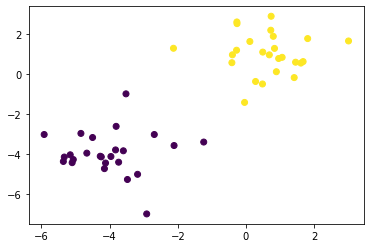

In [34]:
No_sample = 50
mean1=np.array([-4,-4])
var1=np.array([[1,0],[0,1]])
mean2=np.array([1,1])
var2=var1
data1=np.random.multivariate_normal(mean1,var1,int(No_sample/2))
data2=np.random.multivariate_normal(mean2,var2,int(No_sample/2))

# training data generation
X=np.concatenate((data1,data2))
print(X.shape)
y=np.concatenate((-1*np.ones(data1.shape[0]),np.ones(data2.shape[0])))
print(y.shape)

plt.figure()
plt.scatter(X[:,0],X[:,1],marker='o',c=y)

Create a data dictionary, which contains both label and data points.

In [35]:
positiveX=[]
negativeX=[]

## Write your code here
# go through y, append corresponding X[i] values to the lists
for ind, val in enumerate(y):
    if val == 1:
        positiveX.append(X[ind])
    else:
        negativeX.append(X[ind])

#our data dictionary
data_dict = {-1:np.array(negativeX), 1:np.array(positiveX)} 

# print(data_dict) 
# -1 : array of all (x,y) in class -1
# 1 : array of all (x,y) in class 1


## SVM training
1. create a search space for w (i.e w1=w2),[0, 0.5*max((abs(feat)))] and  for b, [-max((abs(feat))),max((abs(feat)))], with appropriate step.
2. we will start with a higher step and find optimal w and b, then we will reduce the step and again re-evaluate the optimal one.

3. In each step, we will take transform of w, [1,1], [-1,1],[1,-1] and [-1,-1] to search arround the w. 

4. In every pass (for a fixed step size) we will store all the w, b and its corresponding ||w||, which make the data correctly classified as per the condition $y(wx+b) \geq 1$. 

5. Obtain the optimal hyperplane having minimum ||w||.

6. Start with the optimal w and repeat the same (step 3,4 and 5) for a reduced step size.


In [36]:
# Just a searching algorithm, not a complicated optimization algorithm, (just for understanding of concepts through visualization)

def SVM_Training(data_dict):
    # insert your code here

    # step 1:
    wb_dict = {}

    transforms = [[1,1], [-1,1], [-1,-1], [1,-1]]
    all_data = []
    w = 0
    b = 0

    # for each label
    for yi in data_dict:
        # for each FV in that label
        for featureset in data_dict[yi]:
            # for each feature
            for feature in featureset:
                all_data.append(feature)
    # from this 1d array, get max, min
    max_val = max(all_data)
    min_val = min(all_data)

    # support vectors: yi(xi.w+b) = 1
    w_step = [max_val * 0.1, max_val * 0.01, max_val * 0.001] # reducing steps of w
    
    b_step = 2
    b_multiple = 5
    w_best = max_val * 0.5

    # diff steps of w
    for step in w_step:
        w = np.array([w_best, w_best]) # take w1=w2. each time we run this loop we narrow down on best w
        optimized = False
        while not optimized:
            for b in np.arange(-1*(max_val*b_step), max_val*b_step, step*b_multiple): # diff values of b
                for tr in transforms: # transform w in diff dirns
                    w_t = w*tr
                    correct_class = True
                    # go thru each FV in each label, check misclassificn; if any are misclassified then return false
                    # this is quite strict but relaxations could be done as well keeping a slack variable (in non-linsep cases)
                    for yi in data_dict:
                        for xi in data_dict[yi]:
                            # condition for correct classification
                            if not yi*(np.dot(w_t, xi) + b) >= 1:
                                correct_class = False
                                break
                    # if data was linearly separated
                    if correct_class:
                        wb_dict[np.linalg.norm(w_t)] = [w_t, b] # ||w|| : [w,b]
            # keep decrementing w by step until it hits 0
            if w[0] < 0:
                optimized = True
                print("w got optimized")
            else:
                w = w - step

        norms = sorted([n for n in wb_dict])    # arranges in increasing order of ||w||
        w, b = wb_dict[norms[0]]                # get the w, b of corresponding min ||w||
        w_best = w[0]

    return w, b


**Training**

In [37]:
# All the required variables 
w=[] # Weights 2 dimensional vector
b=[] # Bias

w,b=SVM_Training(data_dict)
print(w)
print(b)

w got optimized
w got optimized
w got optimized
[0.65891614 0.65891614]
1.9707309077808368


## Visualization of the SVM separating hyperplanes (after training)

In [38]:
def visualize(data_dict):
       
        plt.scatter(X[:,0],X[:,1],marker='o',c=y)

        # hyperplane = x.w+b
        # v = x.w+b
        # psv = 1
        # nsv = -1
        # dec = 0
        def hyperplane_value(x,w,b,v):
            return (-w[0]*x-b+v) / w[1]

        
        hyp_x_min = np.min([np.min(data_dict[1]),np.min(data_dict[-1])])
        hyp_x_max = np.max([np.max(data_dict[1]),np.max(data_dict[-1])])

        # (w.x+b) = 1
        # positive support vector hyperplane
        psv1 = hyperplane_value(hyp_x_min, w, b, 1)
        psv2 = hyperplane_value(hyp_x_max, w, b, 1)
        plt.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')

        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane_value(hyp_x_min, w, b, -1)
        nsv2 = hyperplane_value(hyp_x_max, w, b, -1)
        plt.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # positive support vector hyperplane
        db1 = hyperplane_value(hyp_x_min, w, b, 0)
        db2 = hyperplane_value(hyp_x_max, w, b, 0)
        plt.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')
        
        
        

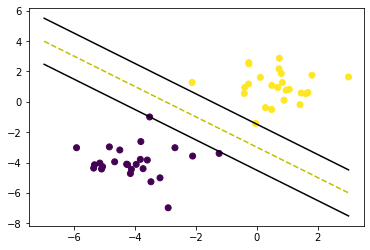

In [39]:
fig = plt.figure()
visualize(data_dict)

**Testing**

In [40]:
def predict(data,w,b):
  y_pred = np.sign(np.dot(data,w) + b) ## write your code here
  return y_pred

test accuracy= 100.0


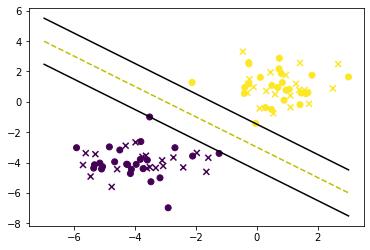

In [41]:
No_test_sample=40

# testing dataset
data1=np.random.multivariate_normal(mean1,var1,int(No_test_sample/2))
data2=np.random.multivariate_normal(mean2,var2,int(No_test_sample/2))
test_data=np.concatenate((data1,data2))
y_gr=np.concatenate((-1*np.ones(data1.shape[0]),np.ones(data2.shape[0])))

# evaluate with the trained model

y_pred = predict(test_data,w,b)
misclass = np.abs(0.5*np.sum(y_pred - y_gr)) # 1-(-1) = 2, -1-(1) = -2 => 1, -1 => 1
accuracy = (1-(misclass/y_pred.shape[0]))*100
print('test accuracy=',accuracy)

#  Visualization
plt.figure()
visualize(data_dict)
plt.scatter(test_data[:,0],test_data[:,1],marker='x',c=y_gr)


**Use the Sci-kit Learn Package and perform Classification on the above dataset using the SVM algorithm**

In [42]:
## Write your code here
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix as conf_mat

# training data: (X, y)
# testing data: (test_data, y_gr)
model = SVC(kernel = "linear")
model.fit(X, y)

# get prediction score on test dataset
y_pred = model.predict(test_data)
sc = model.score(test_data, y_gr)
st = model.score(X, y)

print("Training Accuracy: " + str(st*100))
print("Testing Accuracy: " + str(sc*100))
print("Confusion matrix=\n ", conf_mat(y_gr,y_pred))


Training Accuracy: 100.0
Testing Accuracy: 100.0
Confusion matrix=
  [[20  0]
 [ 0 20]]


# K-Nearest Neighbours (KNN)

Text(0.5, 1.0, 'Data visualization')

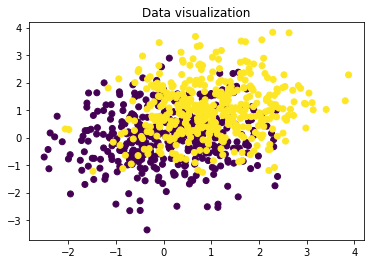

In [43]:
import numpy as np
import matplotlib.pyplot as plt

mean1=np.array([0,0])
mean2=np.array([1,1])
var=np.array([[1,0.1],[0.1,1]])
np.random.seed(0)
data1=np.random.multivariate_normal(mean1,var,500)
data2=np.random.multivariate_normal(mean2,var,500)

# training data
data_train=np.concatenate((data1[:-100,],data2[:-100]))
label=np.concatenate((np.zeros(data1.shape[0]-100),np.ones(data2.shape[0]-100)))

plt.figure()
plt.scatter(data_train[:,0],data_train[:,1],c=label)
plt.title('Data visualization')
plt.show()

In [44]:
def euclidean_distance(row1, row2):
  return np.linalg.norm(row1-row2)

In [45]:
def get_neighbors(train, label_train, test_row, num_neighbors):
  ## write your code here
  distance = []
  for i in range(train.shape[0]):
    train_row = train[i, :]               # get ith training FV, and corresponding label
    train_label = label_train[i]
    d = euclidean_distance(test_row, train_row)
    distance.append((train_row, train_label, d))
    
  distance.sort(key=lambda tup: tup[2])

  neighbors = []
  for i in range(num_neighbors):
    neighbors.append(distance[i])    

  return neighbors


In [46]:
def predict_classification(neighbors):
  ## write your code here
  prediction = []
  for i in range(len(neighbors)):
        prediction.append(neighbors[i][1])
  prediction = max(set(prediction), key=prediction.count)
  return prediction


In [47]:
# test data generation
data_test=np.concatenate((data1[-100:],data2[-100:]))
label_test=np.concatenate((np.zeros(100),np.ones(100)))

In [71]:
K=2

pred_label=np.zeros(data_test.shape[0])
for i in range(data_test.shape[0]):
  neig=get_neighbors(data_train,label, data_test[i,:], K)
  pred_label[i]=predict_classification(neig)

accuracy=(len(np.where(pred_label==label_test)[0])/len(label_test))*100
print('Testing Accuracy=',accuracy)

Testing Accuracy= 65.5


**Use the Sci-kit Learn Package and perform Classification on the above dataset using the K-Nearest Neighbour algorithm**

In [70]:
## Write your code here
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=2)
model.fit(data_train, label)

pred_label_te = model.predict(data_test)
pred_label_tr = model.predict(data_train)

te_accuracy=(len(np.where(pred_label_te==label_test)[0])/len(label_test))*100
tr_accuracy=(len(np.where(pred_label_tr==label)[0])/len(label))*100
print('Testing Accuracy =',te_accuracy)
print('Training Accuracy =',tr_accuracy)

Testing Accuracy = 65.5
Training Accuracy = 83.25


# Classification on MNIST Digit Data

1. Read MNIST data and perform train-test split
2. Select any 2 Classes and perform classification task using SVM, KNN and Logistic Regression algorithms with the help of Sci-Kit Learn tool
3. Report the train and test accuracy and also display the results using confusion matrix
4. Repeat steps 2 and 3 for all 10 Classes and tabulate the results

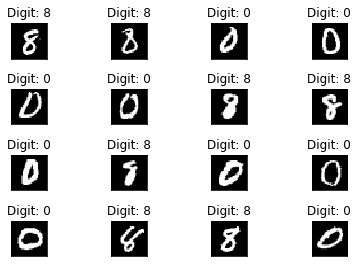

In [63]:
## Write your code here
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import idx2numpy

# 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9
img_file = 't10k-images-idx3-ubyte'
lab_file = 't10k-labels-idx1-ubyte'
x = idx2numpy.convert_from_file(img_file)
y = idx2numpy.convert_from_file(lab_file)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

class_0 = 0
class_1 = 8

# get indices of images of reqd classes
i, = np.where(y_train == class_0)
j, = np.where(y_train == class_1)
# get data from those indices (for each class)
class_0_train = x_train[i, :, :]
class_0_label = y_train[i]
class_1_train = x_train[j, :, :]
class_1_label = y_train[j]

train_fv = np.concatenate((class_0_train, class_1_train), axis=0)
train_lab = np.concatenate((class_0_label,class_1_label), axis=0)

[train_fv_s, train_lab_s] = shuffle(train_fv, train_lab)

plt.figure()
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  plt.imshow(train_fv_s[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(train_lab_s[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()



In [64]:
# replace the labels with 0 and 1 for simplicity
np.place(train_lab_s, train_lab_s==class_0, [0])
np.place(train_lab_s, train_lab_s==class_1, [1])

train_fv_s = train_fv_s.astype('float32')

train_fv_s /= 255

flat_train_fv_s = train_fv_s.reshape(train_lab_s.shape[0], 28*28)


In [65]:
i, = np.where(y_test == class_0)      
j, = np.where(y_test == class_1)
class_0_test = x_test[i, :, :]
class_0_tlabel = y_test[i]
class_1_test = x_test[j, :, :]
class_1_tlabel = y_test[j]

test_fv = np.concatenate((class_0_test, class_1_test), axis=0)
test_lab = np.concatenate((class_0_tlabel, class_1_tlabel), axis=0)

np.place(test_lab, test_lab==class_0, [0])
np.place(test_lab, test_lab==class_1, [1])

test_fv = test_fv.astype('float32') / 255
flat_test_fv = test_fv.reshape(test_lab.shape[0], 28*28)


In [66]:
# posX=[]
# negX=[]
# for ind, val in enumerate(train_lab_s):
#     if val == 1:
#         posX.append(train_fv_s[ind])
#     else:
#         negX.append(train_fv_s[ind])

# #our data dictionary
# data_dict2 = {-1:np.array(negX), 1:np.array(posX)}
# print(data_dict2)
# w_pred, b_pred = SVM_Training(data_dict2)
# visualize(data_dict2)


In [75]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix as conf_mat
svm = LinearSVC()
n = 2000
svm.fit(flat_train_fv_s[0:n,:], train_lab_s[0:n])
tr_acc_svm = svm.score(flat_train_fv_s[0:n,:], train_lab_s[0:n])
print('Training accuracy =', tr_acc_svm*100)

y_pred = svm.predict(flat_test_fv)
te_acc_svm = svm.score(flat_test_fv, test_lab)
print('Testing accuracy = ', te_acc_svm*100)
print('Confusion matrix =\n', conf_mat(test_lab, y_pred))


Training accuracy = 100.0
Testing accuracy =  99.28698752228165
Confusion matrix =
 [[285   1]
 [  3 272]]


In [76]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=2)
model.fit(flat_train_fv_s, train_lab_s)

pred_label_te = model.predict(flat_test_fv)
pred_label_tr = model.predict(flat_train_fv_s)

te_acc_knn = (len(np.where(pred_label_te==test_lab)[0])/len(test_lab))*100
tr_acc_knn = (len(np.where(pred_label_tr==train_lab_s)[0])/len(train_lab_s))*100

print('Testing Accuracy =', te_acc_knn)
print('Training Accuracy =', tr_acc_knn)
print('Confusion Matrix =\n', conf_mat(test_lab, pred_label_te))

Testing Accuracy = 98.93048128342245
Training Accuracy = 99.35391241923905
Confusion Matrix =
 [[286   0]
 [  6 269]]


In [79]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(solver='liblinear')
reg.fit(flat_train_fv_s[0:2000,:], train_lab_s[0:2000])
tr_acc_lr = reg.score(flat_train_fv_s[0:2000,:], train_lab_s[0:2000])
print('Training accuracy =', tr_acc_lr*100)
y_pred = reg.predict(flat_test_fv)
te_acc_lr = reg.score(flat_test_fv, test_lab)
print('Testing accuracy =', te_acc_lr*100)
print('Confusion matrix =\n', conf_mat(test_lab, y_pred))

Training accuracy = 100.0
Testing accuracy = 99.28698752228165
Confusion matrix =
 [[285   1]
 [  3 272]]


**Note : If you are interested, also try classifying MNIST digit data using the code you have written for SVM, KNN and Logistic Regression** 

  